# Analzying Jane Austen's Novels

In honor of Jane Austen's 250th birthday we will be using her novels to begin to explore text analysis. You'll learn how to analyze the text of Jane Austen's novels using Python. We'll cover text collection, sentiment analysis, and some basic visualization techniques.

In [4]:
## Import necessary libraries
## data table manipulation and analysis
import pandas as pd

## regular expressions, csv handling, counting elements
import re
import csv
from collections import Counter

## handling byte streams and https requests
from io import BytesIO
import requests

## sentiment analysis and natural language processing
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer  ## library for sentiment analysis
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

## plotting and visualization
import matplotlib.pyplot as plt

AttributeError: module 'numpy' has no attribute '__version__'

In [16]:
GUTENBERG_CSV_URL = "https://www.gutenberg.org/cache/epub/feeds/pg_catalog.csv.gz"

r = requests.get(GUTENBERG_CSV_URL)
with BytesIO(r.content) as f:
    df = pd.read_csv(f, compression='gzip', quoting=csv.QUOTE_ALL)
df.head()

,Text#,Type,Issued,Title,Language,Authors,Subjects,LoCC,Bookshelves
0,1,Text,1971-12-01,The Declaration of Independence of the United ...,en,"Jefferson, Thomas, 1743-1826","United States -- History -- Revolution, 1775-1...",E201; JK,Politics; American Revolutionary War; United S...
1,2,Text,1972-12-01,The United States Bill of Rights\r\nThe Ten Or...,en,United States,Civil rights -- United States -- Sources; Unit...,JK; KF,Politics; American Revolutionary War; United S...
2,3,Text,1973-11-01,John F. Kennedy's Inaugural Address,en,"Kennedy, John F. (John Fitzgerald), 1917-1963",United States -- Foreign relations -- 1961-196...,E838,"Category: Essays, Letters & Speeches; Category..."
3,4,Text,1973-11-01,Lincoln's Gettysburg Address\r\nGiven November...,en,"Lincoln, Abraham, 1809-1865",Consecration of cemeteries -- Pennsylvania -- ...,E456,"US Civil War; Category: Essays, Letters & Spee..."
4,5,Text,1975-12-01,The United States Constitution,en,United States,United States -- Politics and government -- 17...,JK; KF,United States; Politics; American Revolutionar...


In [21]:
austen_rows = df[(df['Authors'].str.contains('Austen, Jane', na=False)) & (df['Type'] == 'Text') & (df['Language'] == 'en')][:8]

austen_rows

,Text#,Type,Issued,Title,Language,Authors,Subjects,LoCC,Bookshelves
104,105,Text,1994-02-01,Persuasion,en,"Austen, Jane, 1775-1817",England -- Social life and customs -- 19th cen...,PR,Category: Novels; Category: British Literature
120,121,Text,1994-04-01,Northanger Abbey,en,"Austen, Jane, 1775-1817",England -- Social life and customs -- 19th cen...,PR,Gothic Fiction; Category: Novels; Category: Cl...
140,141,Text,1994-06-01,Mansfield Park,en,"Austen, Jane, 1775-1817",England -- Fiction; Young women -- Fiction; Lo...,PR,Category: Novels; Category: British Literature
157,158,Text,1994-08-01,Emma,en,"Austen, Jane, 1775-1817",Humorous stories; England -- Fiction; Young wo...,PR,Category: Novels; Category: British Literature
160,161,Text,1994-09-01,Sense and Sensibility,en,"Austen, Jane, 1775-1817",England -- Social life and customs -- 19th cen...,PR,Category: Romance; Category: Novels; Category:...
927,946,Text,1997-06-01,Lady Susan,en,"Austen, Jane, 1775-1817",England -- Fiction; Widows -- Fiction; Mate se...,PR,Category: Novels; Category: British Literature
1190,1212,Text,1998-02-01,Love and Freindship [sic],en,"Austen, Jane, 1775-1817",Essays; Epistolary fiction; England -- Social ...,PR,Category: Romance; Category: Humour; Category:...
1320,1342,Text,1998-06-01,Pride and Prejudice,en,"Austen, Jane, 1775-1817",England -- Fiction; Young women -- Fiction; Lo...,PR,Best Books Ever Listings; Harvard Classics; Ca...


In [35]:
all_books_text = {}

In [36]:
def clean_sentence(sentence):
    """Clean a sentence by removing punctuation and converting to lowercase."""
    # Remove asterisks, underscores, and other decorative symbols
    cleaned_sentence = re.sub(r'[_*#<>+=\\/\[\]{}|]', '', sentence)


    # Replace multiple newlines or spaces with single space
    cleaned_sentence = re.sub(r'\s+', ' ', cleaned_sentence)

    # Remove weird characters (non-ASCII)
    cleaned_sentence = cleaned_sentence.encode('ascii', errors='ignore').decode()

    # Strip leading/trailing spaces
    cleaned_sentence = cleaned_sentence.strip()

    return cleaned_sentence

Successfully retrieved the book Persuasion.
Successfully retrieved the book Northanger Abbey.
Successfully retrieved the book Mansfield Park.
Successfully retrieved the book Emma.
Successfully retrieved the book Sense and Sensibility.
Successfully retrieved the book Lady Susan.
Successfully retrieved the book Love and Freindship [sic].
Successfully retrieved the book Pride and Prejudice.


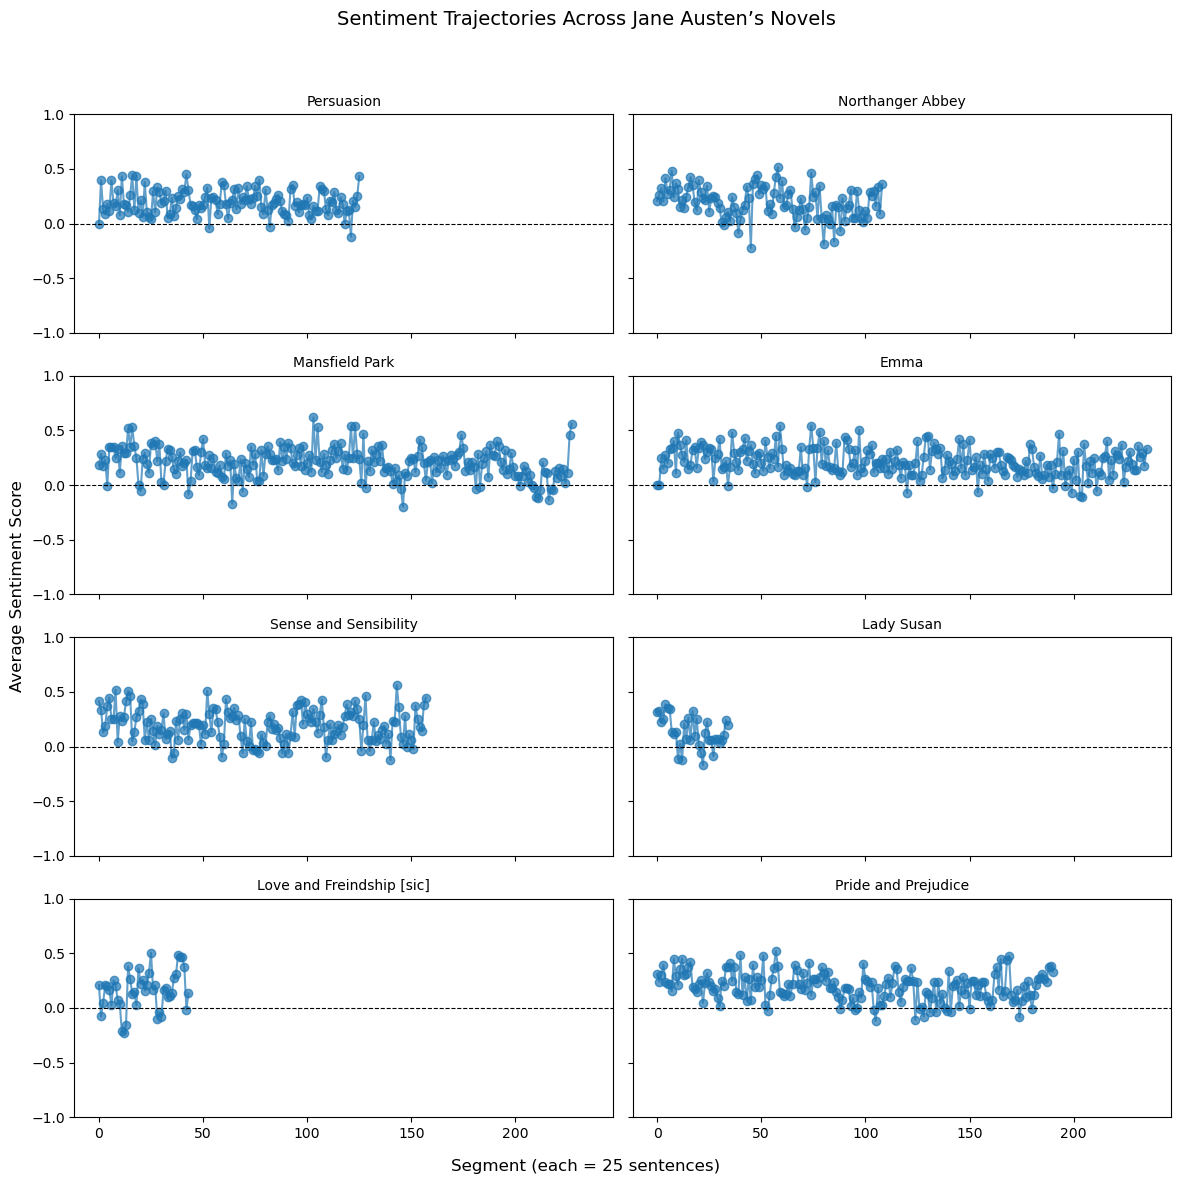

In [58]:
n_books = len(austen_rows)
n_cols = 2  # Adjust for layout you like
n_rows = (n_books + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12), sharex=True, sharey=True)
axes = axes.flatten()

segment = 25
sia = SentimentIntensityAnalyzer()

for idx, bookID in enumerate(austen_rows["Text#"]):
    url = f"https://www.gutenberg.org/cache/epub/{bookID}/pg{bookID}.txt"
    bookname = austen_rows[austen_rows["Text#"] == bookID]["Title"].values[0]
    
    response = requests.get(url)  ## Make a GET request to the URL
    if response.status_code == 200:  ## Check if the request was successful
        print(f"Successfully retrieved the book {bookname}.")
        text = response.text
    else:
        print(f"Failed to retrieve the book page. Status code: {response.status_code}")

    # Clean the text

    ## remove the header and footer from the response text 
    start = response.text.find("*** START OF THE PROJECT GUTENBERG EBOOK")  ## Find the start of the book text
    end = response.text.find("*** END OF THE PROJECT GUTENBERG EBOOK")  ## Find the end of the book text
    cleaned_text = response.text[start:end]  ## Extract the book text between the start and end markers

    all_books_text[bookID] = [bookname, cleaned_text] ## store the book name and cleaned text in a dictionary

    words = re.findall(r'\b[a-z]+\b', cleaned_text.lower()) ## find all words in the cleaned text
    words = [word for word in words if word not in stop_words] ## remove stop words from the list of words
    word_counts = Counter(words) ## count the frequency of each word in the list of words


    """
    print(f"Most common words in {bookname}:")
    for word, count in word_counts.most_common(10): ## Print the 10 most common words
        print(f"{word}: {count}")
    """

    sentences = nltk.sent_tokenize(cleaned_text)  ## split the cleaned text into sentences using NLTK's sentence tokenizer

    results = []

    for sentence in sentences:
        cleaned_sentence = clean_sentence(sentence)
        sentiment_scores = sia.polarity_scores(cleaned_sentence)  ## Get the sentiment scores for the sentence
        results.append((cleaned_sentence, sentiment_scores['compound']))  ## Append the sentiment scores to the results list

    sentiment_df = pd.DataFrame(results, columns=['Sentence', 'Sentiment']) ## Convert the results list to a DataFrame

    # Extract sentiment scores only
    sentiment_scores = [s for (_, s) in results]
    
    # Compute average sentiment per segment
    avgScores = {
        i: sum(sentiment_scores[i*segment:(i+1)*segment]) / segment
        for i in range(len(sentiment_scores)//segment)
    }

    # Plot each book in its own panel
    ax = axes[idx]
    ax.plot(list(avgScores.keys()), list(avgScores.values()), 
            marker='o', linestyle='-', alpha=0.7)
    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax.set_title(bookname, fontsize=10)
    ax.set_ylim(-1, 1)


# Clean up any unused subplots
for ax in axes[len(austen_rows):]:
    ax.axis('off')

fig.suptitle("Sentiment Trajectories Across Jane Austen’s Novels", fontsize=14)
fig.supxlabel(f"Segment (each = {segment} sentences)")
fig.supylabel("Average Sentiment Score")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

